<a href="https://colab.research.google.com/github/EtzionR/LM4GeoAI/blob/main/Geo_Semantic_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.4 MB/s eta 0:00:00


In [2]:
from time import time as get_time
from transformers import pipeline
from shapely import Point
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import numpy as np

In [3]:
FOOD = {'restaurant','fast_food','cafe'}
FOOD

{'cafe', 'fast_food', 'restaurant'}

In [4]:
place = "Paris, France"

tags = {"amenity": True}

In [25]:
START = get_time()

pois = ox.features_from_place(place, tags)

END = get_time()

In [26]:
pois = pois[['name', 'amenity', 'geometry']].dropna().rename(columns={'amenity':'place_type'}).to_crs("EPSG:32631")
pois['IsFood'] = pois.place_type.apply(lambda value: value in FOOD)
print(f'Time to extarct data from OSM: {round(END-START,1)} seconds ({round((END-START)/60,1)} minutes)\n\n')

pois.shape

Time to extarct data from OSM: 61.4 seconds (1.0 minutes)




(26498, 4)

In [28]:
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  
element id                                                
node    21662099  POINT (452320.712 5411188.723)   False  
        24910582  POINT (445834.511 5412487.964)   False  
        25213384  POINT (446146.834 5409337.476)   False  
        25214653  POINT (453864.466 5414327.112)   False  
        27415802  POINT (448842.707 5414715.887)   False

In [31]:
pois.IsFood.mean()

# from utm import from_latlon

# from_latlon(48.858359, 2.295362)

# # 448315 5411949

np.float64(0.5253226658615745)

In [9]:
pois.place_type.value_counts().head(10)

,count
place_type,
restaurant,8758
fast_food,2754
cafe,2408
bar,1799
school,1234
bicycle_rental,1052
bank,912
pharmacy,874
social_facility,461


In [10]:
MODEL = "intfloat/multilingual-e5-large"

TEXT = "restaurant"

embedder = pipeline("feature-extraction", model=MODEL)

get_text_embedding = lambda text: np.array(embedder(text)[0]).max(0)

get_text_embedding(TEXT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cpu


array([ 1.23215318,  0.75919527, -0.22321977, ..., -0.21436638,
       -0.85060573,  1.06850529])

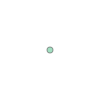

In [29]:
# Eiffel Tower ("Tour Eiffel")

# WGS84 GEO DD X = 2.2952925, Y = 48.8581082
# WGS84 GEO UTM 30N X = -2170417, Y = 3073173

EIFFEL = Point(448315, 5411949)
EIFFEL

In [30]:
pois['distance'] = pois.geometry.distance(EIFFEL).round(2)
pois.head()

name      place_type  \
element id                                                         
node    21662099                      Notre-Dame  ferry_terminal   
        24910582  Embarcadère du Chalet des Îles  ferry_terminal   
        25213384       Relais Total Du Pont Aval            fuel   
        25214653        Relais des Chaufourniers            fuel   
        27415802                 Paris 17 Wagram     post_office   

                                        geometry  IsFood  distance  
element id                                                          
node    21662099  POINT (452320.712 5411188.723)   False   4077.22  
        24910582  POINT (445834.511 5412487.964)   False   2538.37  
        25213384  POINT (446146.834 5409337.476)   False   3394.26  
        25214653  POINT (453864.466 5414327.112)   False   6037.55  
        27415802  POINT (448842.707 5414715.887)   False   2816.76

In [13]:
eiffel_radius = pois[pois['distance']<2000]
eiffel_radius.shape

(2221, 5)

In [14]:
eiffel_radius['repr'] = [get_text_embedding(text) for text in tqdm(eiffel_radius.name)]

eiffel_radius.head()

100%|██████████| 2221/2221 [12:56<00:00,  2.86it/s]
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


name   place_type  \
element id                                                        
node    29434739             Paris École Militaire  post_office   
        241110355           Bibliothèque Vaugirard      library   
        243842886  Parking Quai branly-Tour Eiffel      parking   
        251758250                            Qasim   restaurant   
        251758251                             Diep   restaurant   

                                           geometry  IsFood  distance  \
element id                                                              
node    29434739   POINT (-2169730.829 3072508.741)   False    955.02   
        241110355   POINT (-2170986.15 3071280.681)   False   1976.06   
        243842886  POINT (-2169980.249 3073401.602)   False    492.96   
        251758250  POINT (-2168744.635 3074071.367)    True   1898.39   
        251758251   POINT (-2169276.917 3074129.84)    True   1488.40   

                                                                repr  
element id                                                            
node    29434739   [0.7380593419075012, 0.41761109232902527, 0.58...  
        241110355  [0.7727081775665283, 0.5499475598335266, 0.106...  
        243842886  [1.5052884817123413, 0.5771633386611938, 0.333...  
        251758250  [2.1504738330841064, 1.3921880722045898, -0.49...  
        251758251  [1.0278290510177612, -0.06918773055076599, -0....

In [15]:
food = get_text_embedding("I want something to eat")

cosine_similarity = lambda vec1, vec2: np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

eiffel_radius['L2'] = eiffel_radius.repr.apply(lambda ary: ((food-ary)**2).mean())
eiffel_radius['L1'] = eiffel_radius.repr.apply(lambda ary:  np.abs(food-ary).mean())
eiffel_radius['CS'] = eiffel_radius.repr.apply(lambda ary:  1-cosine_similarity(food,ary))
eiffel_radius['Random'] = np.random.rand(eiffel_radius.shape[0])

eiffel_radius.head()

/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

name   place_type  \
element id                                                        
node    29434739             Paris École Militaire  post_office   
        241110355           Bibliothèque Vaugirard      library   
        243842886  Parking Quai branly-Tour Eiffel      parking   
        251758250                            Qasim   restaurant   
        251758251                             Diep   restaurant   

                                           geometry  IsFood  distance  \
element id                                                              
node    29434739   POINT (-2169730.829 3072508.741)   False    955.02   
        241110355   POINT (-2170986.15 3071280.681)   False   1976.06   
        243842886  POINT (-2169980.249 3073401.602)   False    492.96   
        251758250  POINT (-2168744.635 3074071.367)    True   1898.39   
        251758251   POINT (-2169276.917 3074129.84)    True   1488.40   

                                                                repr  \
element id                                                             
node    29434739   [0.7380593419075012, 0.41761109232902527, 0.58...   
        241110355  [0.7727081775665283, 0.5499475598335266, 0.106...   
        243842886  [1.5052884817123413, 0.5771633386611938, 0.333...   
        251758250  [2.1504738330841064, 1.3921880722045898, -0.49...   
        251758251  [1.0278290510177612, -0.06918773055076599, -0....   

                         L2        L1        CS    Random  
element id                                                 
node    29434739   0.472155  0.549816  0.243712  0.993225  
        241110355  0.447244  0.537225  0.231370  0.271428  
        243842886  0.445518  0.532689  0.222184  0.116871  
        251758250  0.505318  0.560433  0.261883  0.861274  
        251758251  0.466390  0.537964  0.243834  0.495629

In [16]:

Ks = [5, 10, 25, 50, 75, 100, 200, 1000, len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100
evaluation.round(1)


,L2,L1,CS,Random,distance
5,100.0,100.0,100.0,60.0,60.0
10,100.0,100.0,100.0,60.0,40.0
25,92.0,96.0,92.0,52.0,52.0
50,96.0,96.0,96.0,54.0,48.0
75,97.3,96.0,97.3,53.3,48.0
100,96.0,95.0,96.0,51.0,51.0
200,87.0,89.0,89.5,45.0,53.0
1000,61.0,60.7,58.7,47.4,52.1
2221,49.2,49.2,49.2,49.2,49.2


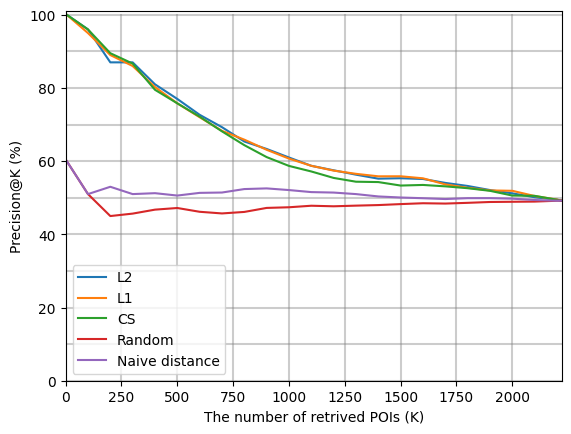

In [17]:
Ks = [5]+[*range(100, len(eiffel_radius), 100)]+[len(eiffel_radius)]

required_columns = [*eiffel_radius.columns[-4:]]+['distance']

evaluation = {method:{k:0 for k in Ks} for method in required_columns}

for method in required_columns:
    for k in Ks:
      evaluation[method][k] = eiffel_radius.sort_values(method).IsFood[:k].mean()

evaluation = pd.DataFrame(evaluation)*100

# ##############################################################################

for col in evaluation.columns:

    plt.plot(evaluation.index, evaluation[col], label=col if col!='distance' else 'Naive distance')

for yi in np.linspace(0,100,11):
    plt.plot([0,len(eiffel_radius)],[yi,yi], color='gray', alpha=.4, zorder=-1)

for xi in np.arange(0,len(eiffel_radius),250):
    plt.plot([xi, xi],[0,100], color='gray', alpha=.4, zorder=-1)

plt.xlabel('The number of retrived POIs (K)')
plt.ylabel('Precision@K (%)')

plt.legend(loc='lower left')
plt.ylim(0,101)
plt.xlim(0,len(eiffel_radius))

plt.show()

